> The idea of this notebook is to create a model to predictc tokens sequence probabilities with the objective of replacing the unknown tokens on the test data with this predicted tokens. The chosen model is a BiLSTM_NN with softmax activation due to these kind of models are state of the art for such tasks if we dont consider transformers or other kind of pretrained models.

# 1. Data preprocessing

In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [2]:
# Read data
df1 = pd.read_json('../Data/domain1_train_data.json', lines=True)
df2 = pd.read_json('../Data/domain2_train_data.json', lines=True)

# Join data in both domains for trating them jointly (Augmentation)
df = pd.concat([df1, df2]).reset_index(drop=True)['text']
df_train, df_test = train_test_split(df, test_size=0.2)

# Transform numbers to strings to treat them as tokens
train_text = [txt for txt in df_train]
test_text = [txt for txt in df_test]

In [104]:
from collections import Counter
# Function to get corpus
def get_vocab(txt):
    l_ = []
    for l in txt:
        l_.extend(l)
    corpus = Counter(l_)
    return corpus
#  Get vocab
vocab = list(set(get_vocab([txt for txt in df]).keys()))
vocab_size = len(vocab)

In [159]:
# Function to build sequence
def build_sequences(text, window):
    x, y = list(), list()
    
    for i in range(len(text)):
        try:
            # Get window of chars from text
            sequence = text[i:i+window]
            target = text[i+window]
            # Save sequences and targets
            x.append(sequence)
            y.append(target)    
        except:
            pass
    return np.array(x), np.array(y)

# Function to create datasets
def get_ds(text):
    x_, y_ = [], []
    for txt in text:
        x, y = build_sequences(txt, 8)
        x_.extend(x)
        y_.extend(y)
    return np.array(x_), np.array(y_)

In [160]:
# Get x_train and y_train
x_train, y_train = get_ds(train_text)
x_test, y_test = get_ds(test_text)

# Build Text Generator model

In [161]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [162]:
# Get cpu, gpu or mps device for training.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [163]:
# Dataset to TensorDataset
train_DS = TensorDataset(torch.from_numpy(x_train).to(device), torch.from_numpy(y_train).to(device))
dev_DS = TensorDataset(torch.from_numpy(x_test).to(device), torch.from_numpy(y_test).int().to(device))

# Create dataloaders
bs = 32
x_tr_dl = DataLoader(train_DS, batch_size=bs, shuffle=True)
x_dev_dl = DataLoader(dev_DS, batch_size=bs, shuffle=True)

In [164]:
# Bidirectional LSTM model
class TextGenerator(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim,
                 n_layers):
        super(TextGenerator, self).__init__()

        # Embeding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # BiLSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, num_layers=n_layers, batch_first=True, dropout = 0.2)
        # Linear layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # x2: bidirectional
        self.dropout = nn.Dropout(0.2)

    def forward(self, text):
        # Embedding
        embedded = self.dropout(self.embedding(text))
        # BiLSTM pass
        output, (hidden, cell_state) = self.lstm(embedded)
        # Concatenate hidden states in the BiLSTM
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        return self.fc(hidden.squeeze(0))

In [171]:
# Model initialization
model = TextGenerator(vocab_size = vocab_size, embedding_dim = 64, hidden_dim = 64, output_dim = vocab_size, n_layers = 2).to(device)
# Loss fn
loss_fn = nn.CrossEntropyLoss()
# Optimizer
optimizer = torch.optim.Adam(model.parameters())
model

TextGenerator(
  (embedding): Embedding(83581, 64, padding_idx=0)
  (lstm): LSTM(64, 64, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=128, out_features=83581, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [172]:
from tqdm import tqdm
# Train
def train(dataloader, model, optimizer):
    softmax = nn.Softmax(dim=1)
    size = len(dataloader.dataset)
    model.train()
    train_loss, acc, total = 0, 0, 0
    for X, y in tqdm(dataloader):
        pred = model(X)                         # Forward pass
        loss = loss_fn(pred, y)                 # Compute loss 
        loss.backward()                         # Backpropagation
        optimizer.step()                        # Update parameters
        optimizer.zero_grad()                   # Reset gradient
    
        # Metrics
        train_loss += loss.item()
        total += len(y)
        result = torch.max(pred,1)[1]
        acc += (result == y).sum().item()
        
    # General metrics
    train_loss /= total
    acc /= size
    return train_loss, acc

# Test
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, acc, total = 0, 0, 0
    with torch.no_grad():       # Specify no gradient
        for X, y in dataloader:
            pred = model(X)                                     # Forward pass
            test_loss += loss_fn(pred, y).item()  # Compute loss     
            
            # Metrics
            result = torch.max(pred,1)[1]           # Results to binary
            acc += (result == y).sum().item()       # Accuracy
            total += len(y)                         # Total observations
            
    # General metrics
    test_loss /= total
    acc /= size
    return test_loss, acc

In [173]:
from tqdm import tqdm, tqdm_notebook # show progress bar

# Epochs
epochs = 10
train_loss, valid_loss = [], []
print("Training Text generator model!")
for t in range(epochs):
    tl, train_acc = train(x_tr_dl, model, optimizer)
    vl, valid_acc = test(x_dev_dl, model)
    # Losses to dict
    train_loss.append(tl)
    valid_loss.append(vl)
    # Print results
    tqdm.write(
        f'epoch #{t}\ttrain_acc: {train_acc:.3f}\tvalid_acc: {valid_acc:.3f}',
    )

Training Text generator model!


  0%|          | 371/105781 [00:16<1:19:07, 22.20it/s]


KeyboardInterrupt: 

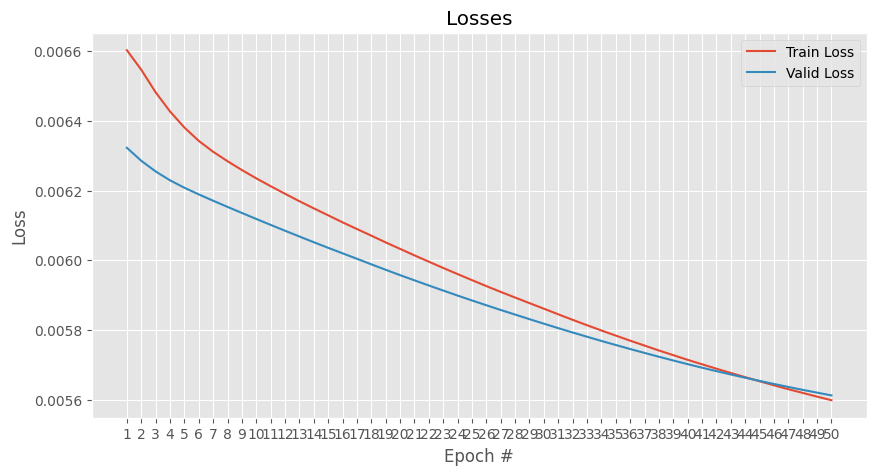

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
epoch_ticks = range(1, epochs + 1)
plt.plot(epoch_ticks, train_loss)
plt.plot(epoch_ticks, valid_loss)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses') 
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()